# 모델_1 긍정/부정 분류에 사용해볼 전처리
fasttext적용위치\
불용어제거하고\
okt또는 macab 토큰화 후에 적용


In [14]:
#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd

#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::4]

#널값제거
df_train.dropna(inplace=True)



In [15]:
#문장 추출
texts= [ ]
for i in df_train['text']:
    texts.append(i)
len(texts)

#문자열이 아닌게 있는지 확인
for i in texts:
    if type(i)!=str:
        print(i)
        
# train 데이터 입력값(X)을 정제(Cleaning)
import re
from soynlp.normalizer import repeat_normalize

def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', '', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

clean_texts=[]
for i in texts:
    clean_texts.append(clean_korean_text(i))


In [16]:
# len(clean_texts)
clean_texts[:5]

['아 더빙 진짜 짜증나네요 목소리',
 '사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다그냥 까고싶어서 안달난것처럼 보인다']

In [17]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
#불용어제거도 같이한다.
from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:/mecab/mecab-ko-dic')
from konlpy.tag import Okt
okt=Okt()

tokenized_clean_texts =[ mecab.morphs(i) for i in clean_texts ]
tokenized_clean_texts

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['사이몬페그',
  '의',
  '익살',
  '스런',
  '연기',
  '가',
  '돋보였',
  '던',
  '영화',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '가',
  '너무나',
  '도',
  '이뻐',
  '보였',
  '다'],
 ['액션', '이', '없', '는데', '도', '재미', '있', '는', '몇', '안', '되', '는', '영화'],
 ['울',
  '면서',
  '손들',
  '고',
  '횡단',
  '보도',
  '건널',
  '때',
  '뛰쳐나올',
  '뻔',
  '이범수',
  '연기',
  '드럽',
  '게',
  '못해'],
 ['참',
  '사람',
  '들',
  '웃긴',
  '게',
  '바스코',
  '가',
  '이기면',
  '락스',
  '코',
  '라고',
  '까',
  '고',
  '바비',
  '가',
  '이기',
  '면',
  '아이돌',
  '이',
  '라고',
  '깐다',
  '그냥',
  '까',
  '고',
  '싶',
  '어서',
  '안달',
  '난',
  '것',
  '처럼',
  '보인다'],
 ['나름',
  '심오',
  '한',
  '뜻',
  '도',
  '있',
  '는',
  '듯',
  '그냥',
  '학생',
  '이',
  '선생',
  '과',
  '놀아나',
  '는',
  '영화',
  '는',
  '절대',
  '아님'],
 ['주제', '는', '좋', '은데', '중반', '부터', '지루', '하', '다'],
 ['재', '밋', '는', '뎅'],
 ['재밌', '는데', '별점', '이', '왜', '이리', '낮', '은고'],
 ['키이라',
  '나이틀리',
  '가',
  '연기',
  '하',
  '고자',

리뷰의 최대 길이 : 94
리뷰의 평균 길이 : 16.093626666666665


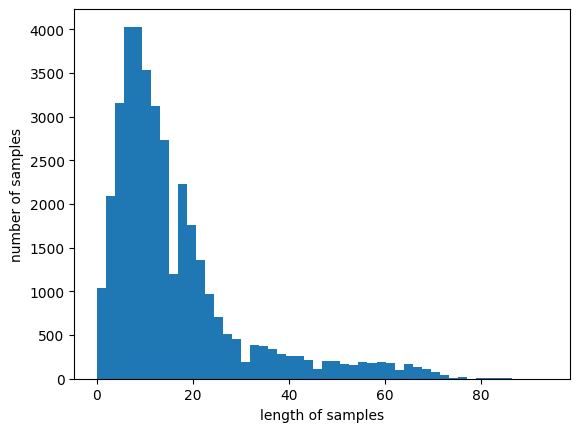

In [18]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_clean_texts))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_clean_texts))/len(tokenized_clean_texts))
plt.hist([len(review) for review in tokenized_clean_texts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

한국어 mecab.morph() 토큰화를 거친뒤, 다시 문장으로 합쳐주고
tokenizer를 사용해 벡터화한다.

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# 35000개 = 실무에서 일반적으로 사용하는? 갯수
#cleaned_sentences의 빈도수 35000개 어절을 토크나이저에 fit시킴
vocab_size=35000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(tokenized_clean_texts)

# tokenizer 객체를 저장
with open('FT_lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

#시퀀스데이터로 변환 ==벡터화
sequences = tokenizer.texts_to_sequences(tokenized_clean_texts)

In [20]:
#길이를 맞춰주는 패딩작업,평균 길이가 16이기 때문에 배수인 32으로
max_len =32
x_train = pad_sequences(sequences, maxlen= max_len, padding='post')

In [21]:
#y값 추출, 데이터 차원 맞추기, 넘파이 배열로 변환
y_train=(df_train.iloc[:,1].to_frame()).to_numpy()
y_train

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [1]], dtype=int64)

In [22]:
#시퀀스 길이확인
print(x_train[0])
x_train.shape

[ 35  80 943  41 245  22  40 646   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


(37500, 32)

패스트텍스트 학습해보기  => 임베딩층에 사전학습모델을 넣어주는것이다.

In [23]:
from gensim.models import FastText
#sg=1 : skipgram사용, 중심단어를 기준으로 주변단어예측
embedding_dim = 200
ft_model = FastText(tokenized_clean_texts, vector_size=embedding_dim, window=5, min_count=5, workers=6, sg=1)
# 완성된 임베딩 매트릭스의 크기 확인
ft_model.wv.vectors.shape

(6580, 200)

In [24]:
#어떤 토큰과 유사도가 있는지 보지, OOV인 토큰을넣어도 쌉가능
print(ft_model.wv.most_similar("최민기"))

[('최민수', 0.9812635183334351), ('이민기', 0.9770328402519226), ('최민식', 0.9710498452186584), ('조한선', 0.9703344702720642), ('존쿠삭', 0.9667711853981018), ('김지수', 0.9657303690910339), ('서우', 0.9655707478523254), ('김정은', 0.9646504521369934), ('신들린', 0.9628695845603943), ('윤진서', 0.9627010226249695)]


In [27]:
# 학습된 입베딩층 모델 저장
# ft_model.save("FT_LSTM_test.bin")

In [28]:
# FastText 임베딩 로드
# import fasttext
fasttext_model = FastText.load('./FT_LSTM_test.bin')

In [29]:
tokenizer.word_index.items()

dict_items([('이', 1), ('는', 2), ('영화', 3), ('다', 4), ('고', 5), ('하', 6), ('도', 7), ('의', 8), ('가', 9), ('은', 10), ('에', 11), ('을', 12), ('한', 13), ('보', 14), ('게', 15), ('들', 16), ('지', 17), ('를', 18), ('있', 19), ('없', 20), ('좋', 21), ('나', 22), ('었', 23), ('만', 24), ('는데', 25), ('너무', 26), ('적', 27), ('안', 28), ('봤', 29), ('로', 30), ('정말', 31), ('음', 32), ('으로', 33), ('것', 34), ('아', 35), ('어', 36), ('재밌', 37), ('지만', 38), ('같', 39), ('네요', 40), ('진짜', 41), ('기', 42), ('했', 43), ('거', 44), ('에서', 45), ('네', 46), ('점', 47), ('않', 48), ('수', 49), ('되', 50), ('았', 51), ('면', 52), ('과', 53), ('인', 54), ('말', 55), ('연기', 56), ('주', 57), ('잘', 58), ('최고', 59), ('평점', 60), ('내', 61), ('어요', 62), ('이런', 63), ('와', 64), ('던', 65), ('할', 66), ('스토리', 67), ('왜', 68), ('겠', 69), ('드라마', 70), ('듯', 71), ('습니다', 72), ('해', 73), ('싶', 74), ('그', 75), ('사람', 76), ('감동', 77), ('아니', 78), ('생각', 79), ('더', 80), ('때', 81), ('함', 82), ('ㅋ', 83), ('배우', 84), ('본', 85), ('까지', 86), ('ㅋㅋ', 87), ('좀', 88), (

In [30]:
fasttext_model.wv['영화']

array([-1.73028819e-02, -2.80538164e-02,  2.74525825e-02,  1.77580360e-02,
        1.72159284e-01, -1.37634113e-01,  2.57182777e-01,  2.19147593e-01,
        7.77268875e-03,  8.18031803e-02,  1.08238511e-01, -1.94757450e-02,
       -7.29549602e-02, -1.42038420e-01, -1.17556237e-01, -1.18695974e-01,
        2.69067101e-03,  4.85803522e-02,  3.14785838e-01, -1.84322596e-01,
        1.56946599e-01,  1.92553416e-01,  4.57243472e-02, -7.17304647e-06,
        5.89942224e-02,  2.39086062e-01, -7.54337311e-02,  6.21470846e-02,
       -3.07074368e-01, -1.70769155e-01,  2.34854609e-01,  5.66167086e-02,
        2.69502029e-02, -8.32739472e-02,  1.12833321e-01, -2.00078469e-02,
        6.57236204e-02, -3.27376246e-01,  1.62251651e-01, -5.57372123e-02,
        3.72894853e-02,  1.33252293e-02,  6.32977784e-02,  1.95094466e-01,
        1.85104162e-01, -2.35300943e-01,  1.15578212e-01, -8.33123773e-02,
        8.35196227e-02, -1.76893473e-01,  8.53816494e-02,  1.28922462e-01,
       -1.65460315e-02,  

In [31]:
# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = fasttext_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
#전처리끝 모델시작

## RNN계열 모델 가져와서 학습시키기

In [32]:
# LSTM 모델 정의
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stop])

Epoch 1/10
235/235 [==============================] - 31s 105ms/step - loss: 0.4967 - accuracy: 0.7542 - val_loss: 0.4345 - val_accuracy: 0.7944
Epoch 2/10
235/235 [==============================] - 24s 100ms/step - loss: 0.4375 - accuracy: 0.7951 - val_loss: 0.4261 - val_accuracy: 0.7933
Epoch 3/10
235/235 [==============================] - 24s 102ms/step - loss: 0.4278 - accuracy: 0.7981 - val_loss: 0.4281 - val_accuracy: 0.8024
Epoch 4/10
235/235 [==============================] - 23s 100ms/step - loss: 0.4182 - accuracy: 0.8064 - val_loss: 0.4163 - val_accuracy: 0.8045
Epoch 5/10
235/235 [==============================] - 24s 103ms/step - loss: 0.4090 - accuracy: 0.8098 - val_loss: 0.4076 - val_accuracy: 0.8087
Epoch 6/10
235/235 [==============================] - 23s 100ms/step - loss: 0.4042 - accuracy: 0.8110 - val_loss: 0.3946 - val_accuracy: 0.8121
Epoch 7/10
235/235 [==============================] - 24s 101ms/step - loss: 0.3965 - accuracy: 0.8133 - val_loss: 0.3893 - val_ac

In [33]:
model.save('./FT_LSTM_test.h5')

In [34]:
#테스트문장 입력
test = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따']

#정제
clean_test_texts=[]
for i in test:
    clean_test_texts.append(clean_korean_text(i))

#mecab
tokenized_test_text = [ mecab.morphs(i) for i in clean_test_texts]

#벡터화
test_sequences = tokenizer.texts_to_sequences(tokenized_test_text) 
x_test = pad_sequences(test_sequences,padding='post',maxlen=32) 

#예측
prediction = model.predict(x_test)  

for i in np.round(prediction):
    print(int(i))

1/1 [==============================] - 1s 561ms/step
0
1
0
1


# 서비스 테스트

In [35]:
#모델 불러오기
from tensorflow.keras.models import load_model
loaded_model= load_model('./FT_LSTM_test.h5')

#저장된 vectorizer 불러오기
import pickle
with open('./FT_lstm_tokenizer.pkl', 'rb') as f:
    loaded_test_vectorizer = pickle.load(f)

In [37]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [38]:
#닉네임 입력단 
# target_name = str(input())
target_name = '김하영'
print(target_name)  #김하영 입력

김하영


In [68]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '사진' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]



#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:/mecab/mecab-ko-dic')
tokenized_clean_test_texts2 =[ mecab.morphs(i) for i in clean_received_texts2 ]

#이미 토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
rejoined_tokenized_test_texts2 = [' '.join(i) for i in tokenized_clean_test_texts2]


# # 학습된 TF-IDF 벡터라이저로 테스트 데이터 변환
test_sequences = loaded_test_vectorizer.texts_to_sequences(rejoined_tokenized_test_texts2)
x_test = pad_sequences(test_sequences,padding='post',maxlen=32) 


# # 모델을 사용하여 예측 수행
predictions = loaded_model.predict(x_test)
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0; cnt2=0
for i in predictions.squeeze().tolist():
    if i <= 0.45:
        cnt0+=1
    elif i >= 0.55:
        cnt1+=1
    else :
        cnt2+=1
        
        

#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
print('중립문장의 갯수:',cnt2)


#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

6/6 [==============================] - 0s 7ms/step
[0.42015233635902405, 0.15778325498104095, 0.4034382998943329, 0.15830516815185547, 0.2756638824939728, 0.23274767398834229, 0.5671480298042297, 0.25340867042541504, 0.4362293481826782, 0.4002711772918701, 0.6111466884613037, 0.06004936248064041, 0.1837492287158966, 0.1312265843153, 0.2406095564365387, 0.08809877932071686, 0.3380661606788635, 0.17884549498558044, 0.544122040271759, 0.5671480298042297, 0.3253222107887268, 0.34540876746177673, 0.34540876746177673, 0.4286506474018097, 0.5671480298042297, 0.28317803144454956, 0.5671480298042297, 0.11938949674367905, 0.4006653428077698, 0.19541098177433014, 0.12212876230478287, 0.31381163001060486, 0.3801400661468506, 0.3815697431564331, 0.5671480298042297, 0.4159267246723175, 0.4814023971557617, 0.3980425298213959, 0.24305537343025208, 0.3207646906375885, 0.12008189409971237, 0.32288381457328796, 0.5671480298042297, 0.5671480298042297, 0.42395874857902527, 0.4516054093837738, 0.19916307926